In [154]:
import numpy as np
from scipy import signal
import window as w
import psychoac as p
import matplotlib.pyplot as plt
import mdct as m
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

## Encoder Methods

In [155]:
def calcSpecEnv(data,cutoff,fs,hfRecType=2):
    # calcSpecEnv - Function to calculate spectral envelope passed to decoder for SBR
    # data:      input signal for current block
    # cutoff:    Cutoff frequency in Hz
    # fs:        Sampling rate in Hz
    # hfRecType: 1 for full subband, 2 for altered subband that repeats top half
    N = data.size
    freqVec = np.arange(0,fs/2,fs/float(N)) # Vector of FFT bin frequencies
    Xn = np.fft.fft(w.HanningWindow(data),N)
    hannWin = (1/float(N))*np.sum(np.power(w.HanningWindow(np.ones_like(data)),2)) # Get avg pow of hann window
    XnI = (4/(np.power(N,2)*hannWin))*(np.power(np.abs(Xn),2)) # Compute values of FFT intensity
    # Transpose down top half of subband if we're using altered alg
    XnI = XnI[0:N/2]
    cutBin = freqToBinFFT(N,cutoff,fs)
    subBand = np.array(XnI[0:cutBin],copy=True)
    if hfRecType==2:
        try:
            subBand[0:int(np.floor(cutBin/2))] = subBand[int(np.floor(cutBin/2)):cutBin]
        except:
            subBand[0:int(np.floor(cutBin/2))] = subBand[int(np.floor(cutBin/2)+1):cutBin]
        # Add in additional high frequencies if there are less
        lowSize = int(len(subBand))
        highSize = int(len(XnI[cutBin:]))
        if lowSize<highSize:
            multiples = highSize/lowSize
            diff = highSize%lowSize
            addition = np.array(subBand,copy=True) # This is the piece to add in each time
            # Add in more copies of low band until sizes are comparable
            for m in range(multiples-1):
                subBand  = np.append(subBand,addition)
            if diff!=0:
                subBand = np.append(subBand,np.zeros(diff))
                subBand[-diff:] = subBand[0:diff]

    bandLimits = p.cbFreqLimits # Zwicker critical band upper limits
    cutBand = np.argwhere(bandLimits>=cutoff)[0] # Next band limit above cutoff freq
    nHfBands = len(bandLimits)-cutBand # How many bands will be reconstructed
    specEnv = np.zeros(nHfBands-1)
    
    recBand = np.append(XnI[0:cutBin],subBand)
    for i in range(nHfBands-1):
        bandLines = np.intersect1d(np.argwhere(freqVec>bandLimits[cutBand+i]),\
                                   np.argwhere(freqVec<=bandLimits[cutBand+i+1]))
        highMean = np.mean(XnI[bandLines]) 
        subSlice = recBand[bandLines]
        subMean = np.mean(subSlice)
        # Spec Env is ratio of avg intensity in each hi-freq critical band to corresponding sub band
        specEnv[i]=highMean/subMean
    specEnv[np.nonzero(np.isnan(specEnv))] = 1 # Get rid of pesky nans
    
    plt.figure(2)
    plt.plot(freqVec,p.SPL(XnI),color='red',lw=2,label='upper band')
    plt.hold(True)
    plt.plot(freqVec,p.SPL(recBand),color='blue',lw=2,label='sub band')
    a = plt.gca()
    a.legend()
    a.axis('tight')
    
    return specEnv

## Decoder Methods

In [156]:
# High Frequency Reconstruction
def HiFreqRec(mdctLines,fs,cutoff,hfRecType=2):
    # hfRecType: 1 means straight bin transposition
    #            2 means altered transposition (default)
    nMDCT = len(mdctLines)
    cutBin = freqToBin(nMDCT,cutoff,fs)
    lowerBand = np.array(mdctLines[0:cutBin],copy=True)
    if hfRecType==1:
        mdctLines[cutBin+1:cutBin+len(lowerBand)+1] = lowerBand # Do the transposition
    elif hfRecType==2:
        try: # Being hacky to account for off by 1 errors
            lowerBand[0:int(np.floor(cutBin/2))] = lowerBand[int(np.floor(cutBin/2)):cutBin]
        except ValueError:
            lowerBand[0:int(np.floor(cutBin/2))] = lowerBand[int(np.floor(cutBin/2)+1):cutBin]
        # Add in additional high frequencies if reconstructed bin doesn't go all the way to nyquist
        lowSize = int(len(lowerBand))
        highSize = int(len(mdctLines[cutBin:]))
        if lowSize<highSize:
            multiples = highSize/lowSize
            diff = highSize%lowSize
            addition = np.array(lowerBand,copy=True) # This is the piece to add in each time
            # Add in more copies of low band until sizes are comparable
            for m in range(multiples-1):
                lowerBand = np.append(lowerBand,addition)
            if diff!=0:
                subBand = np.append(lowerBand,np.zeros(diff))
                lowerBand[-diff:] = lowerBand[0:diff]        
        mdctLines[cutBin+1:cutBin+len(lowerBand)+1] = lowerBand # Do the transposition
    return mdctLines.astype(float) # If these are ints it can cause problems

In [163]:
# Additional High Frequency Components
def AddHiFreqs(mdctLines,fs,cutoff):
    nMDCT = len(mdctLines)
    cutBin = freqToBin(nMDCT,cutoff,fs)
    noiseBins = len(mdctLines[cutBin:])
    mdctLines[cutBin:] += np.absolute(np.random.normal(0,0.0001,noiseBins))# Add some noise to reconstructed bins
    return mdctLines

In [158]:
# Envelope Adjustment (assumes HF Reconstruction has occured)
def EnvAdjust(mdctLines,fs,cutoff,envelope):
    nMDCT = len(mdctLines)
    N = 2*nMDCT
    mdctFreq = np.arange(0,fs/2,fs/float(N))+(fs/float(2.*N))
    bandLimits = p.cbFreqLimits # Zwicker critical band upper limits
    cutBand = np.argwhere(bandLimits>=cutoff)[0] # Next band limit above cutoff freq
    nHfBands = len(envelope)
    tempLines = np.copy(mdctLines)
    
    for i in range(nHfBands):
        # Find MDCT lines in this critical band and apply envelope from encoder
        bandLines = np.intersect1d(np.argwhere(mdctFreq>bandLimits[cutBand+i]),\
                                   np.argwhere(mdctFreq<=bandLimits[cutBand+i+1]))
        bandInt = np.mean(tempLines[bandLines]) # Average intensity in current band
        tempLines[bandLines] *= envelope[i]        
    return tempLines

## Utility

In [159]:
# Utility Function to Convert Cutoff Freq to MDCT Bin number
def freqToBin(nMDCT,cutoff,fs):
    N = 2*nMDCT
    freqVec = np.arange(0,fs/2,fs/float(N))+fs/float(2.*N) # MDCT Frequencies
    cutBin = np.argmin(np.absolute(freqVec-cutoff)) # Find index of cutoff frequency
    return cutBin

In [160]:
# Utility Function to Convert Cutoff Freq to FFT Bin Number
def freqToBinFFT(nFFT,cutoff,fs):
    N = nFFT
    freqVec = np.arange(0,fs/2,fs/float(N)) # FFT freq vector
    cutBin = np.argmin(np.absolute(freqVec-cutoff))
    return cutBin

In [161]:
# Utility Function to Convert cutoff frequency to 
def freqToBand(cutoff):
    bandLimits = p.cbFreqLimits # Zwicker critical band upper limits
    cutBand = np.argwhere(bandLimits>=cutoff)[0] # Next band limit above cutoff freq
    
    return cutBand

## Test Code

len(MDCTlines):  512
len(lowerBand):  339
Band:  [18] Freq [5300]
Spec Env:  [  2.23619778e+07   2.98970913e-04   8.70622688e-11   8.37089482e-09
   3.28580793e+00   2.24395143e-11]


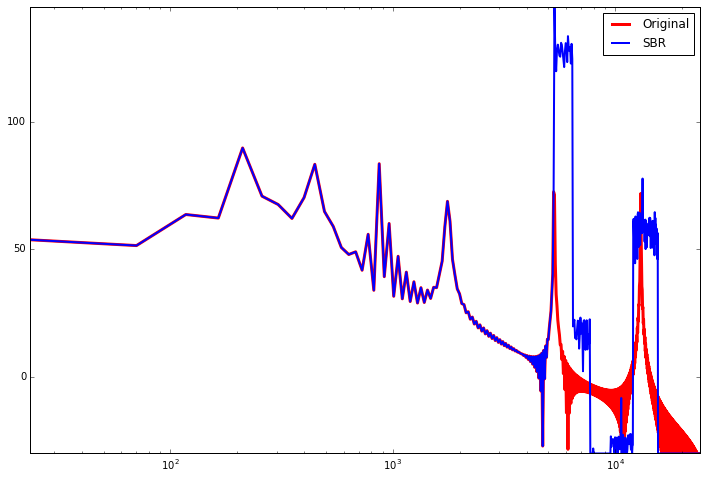

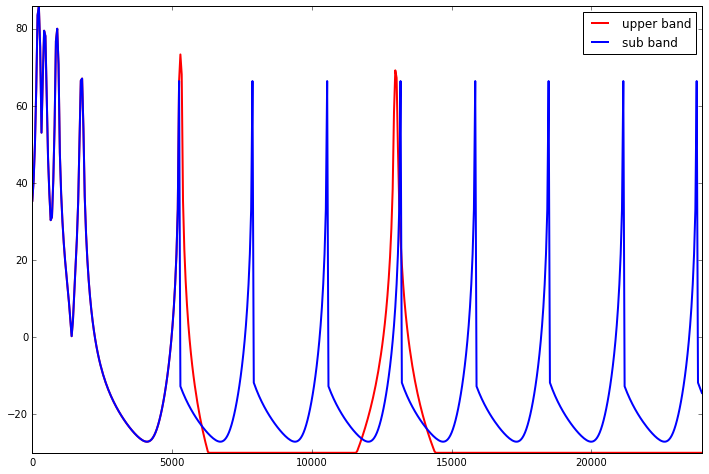

In [165]:
#-----------------------------------------------------------------------------

#Testing code
if __name__ == "__main__": 
    fs = 48000
    T = 1/float(fs)
    N = 1024
    n = np.arange(0,N*T,T)
    freqVec = np.arange(0,fs/2,fs/float(N)) # Vector of frequencies for plotting
    freqMDCT = freqVec + (fs/float(2.*N)) # MDCT Lines
    
    # Test Signal from previous hw
    A = np.array([0.40,0.20,0.20,0.09,0.06,0.05]) # Sinusoidal component amplitudes
    F = np.array([220,440,880,5300,13000,1760]) # Sinusoidal frequencies
    xn = A[0]*np.cos(2*np.pi*F[0]*n) + A[1]*np.cos(2*np.pi*F[1]*n) +\
    A[2]*np.cos(2*np.pi*F[2]*n) + A[3]*np.cos(2*np.pi*F[3]*n) + \
    A[4]*np.cos(2*np.pi*F[4]*n) + A[5]*np.cos(2*np.pi*F[5]*n)

# #     Noise Signal
#     x = np.random.uniform(-1,1,(N))
#     b,a = signal.butter(5,0.25) # lowpass filter
#     xn = signal.lfilter(b,a,x)
    
    
    Xmdct = m.MDCT(w.SineWindow(xn),N/2,N/2) # Compute FFT of signal
    sineWin = (1/float(N))*np.sum(np.power(w.SineWindow(np.ones_like(xn)),2)) # Get avg pow of hann window
    XmI = (2/sineWin)*(np.power(np.abs(Xmdct),2)) # Convert values of FFT to intensity
    
    cutoff = 5300
    
    specEnv = calcSpecEnv(xn,cutoff,fs)
    
    copyBins = np.array(XmI,copy=True)
    newBins = HiFreqRec(copyBins,fs,cutoff)
    noiseBins = AddHiFreqs(newBins,fs,cutoff)
    envBins = EnvAdjust(noiseBins,fs,cutoff,specEnv)

    plt.figure(1)
    plt.semilogx(freqMDCT,p.SPL(XmI),color='red',lw=3,label="Original")
    plt.hold(True)
    plt.semilogx(freqMDCT,p.SPL(envBins),color='blue',lw=2,label="SBR")
    plt.hold(True)
    a = plt.gca()
    a.legend()
    a.axis('tight')
    
    print 'Band: ',freqToBand(cutoff),'Freq',p.cbFreqLimits[freqToBand(cutoff)]
    print 'Spec Env: ',specEnv